## Introduction
to find a shortest closed path or circuit that visits every edge of a (connected) undirected graph.

https://en.wikipedia.org/wiki/Route_inspection_problem

https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial

In [1]:
import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
edgelist = pd.read_csv('../edgelist_sleeping_giant.csv')
# Preview edgelist
edgelist.head(10)

,node1,node2,trail,distance,color,estimate
0,rs_end_north,v_rs,rs,0.30,red,0
1,v_rs,b_rs,rs,0.21,red,0
2,b_rs,g_rs,rs,0.11,red,0
3,g_rs,w_rs,rs,0.18,red,0
4,w_rs,o_rs,rs,0.21,red,0
5,o_rs,y_rs,rs,0.12,red,0
6,y_rs,rs_end_south,rs,0.39,red,0
7,rc_end_north,v_rc,rc,0.70,red,0
8,v_rc,b_rc,rc,0.04,red,0
9,b_rc,g_rc,rc,0.15,red,0


In [8]:
nodelist = pd.read_csv('../nodelist_sleeping_giant.csv')
# Preview edgelist
nodelist.head(10)

,id,X,Y
0,b_bv,1486,732
1,b_bw,716,1357
2,b_end_east,3164,1111
3,b_end_west,141,1938
4,b_g,1725,771
5,b_gy2,2000,983
6,b_o,2039,1012
7,b_rc,1311,979
8,b_rd,268,1744
9,b_rd_dupe,268,1744


In [14]:
# Create empty graph
g = nx.Graph()
# Add edges and edge attributes
for i, elrow in edgelist.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())
# Add node attributes
for i, nlrow in nodelist.iterrows():
    g.node[nlrow['id']].update(nlrow[1:].to_dict())

In [16]:
# Preview first 5 edges
list(g.edges(data=True))[0:5]

[('rs_end_north',
  'v_rs',
  {'attr_dict': {'trail': 'rs',
    'distance': 0.3,
    'color': 'red',
    'estimate': 0}}),
 ('v_rs',
  'b_rs',
  {'attr_dict': {'trail': 'rs',
    'distance': 0.21,
    'color': 'red',
    'estimate': 0}}),
 ('v_rs',
  'v_bv',
  {'attr_dict': {'trail': 'v',
    'distance': 0.52,
    'color': 'violet',
    'estimate': 0}}),
 ('v_rs',
  'v_end_east',
  {'attr_dict': {'trail': 'v',
    'distance': 0.54,
    'color': 'violet',
    'estimate': 0}}),
 ('b_rs',
  'g_rs',
  {'attr_dict': {'trail': 'rs',
    'distance': 0.11,
    'color': 'red',
    'estimate': 0}})]

In [17]:
# Preview first 10 nodes
list(g.nodes(data=True))[0:10]

[('rs_end_north', {'X': 1772, 'Y': 172}),
 ('v_rs', {'X': 1793, 'Y': 484}),
 ('b_rs', {'X': 1747, 'Y': 700}),
 ('g_rs', {'X': 1676, 'Y': 775}),
 ('w_rs', {'X': 1646, 'Y': 947}),
 ('o_rs', {'X': 1724, 'Y': 1148}),
 ('y_rs', {'X': 1805, 'Y': 1246}),
 ('rs_end_south', {'X': 1865, 'Y': 1598}),
 ('rc_end_north', {'X': 867, 'Y': 618}),
 ('v_rc', {'X': 1288, 'Y': 934})]

In [18]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 123
# of nodes: 77


In [19]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['X'], -node[1]['Y']) for node in g.nodes(data=True)}

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:5])

{'rs_end_north': (1772, -172),
 'v_rs': (1793, -484),
 'b_rs': (1747, -700),
 'g_rs': (1676, -775),
 'w_rs': (1646, -947)}

In [31]:
# Define data structure (list) of edge colors for plotting
edge_colors = [e[2]['attr_dict']['color'] for e in g.edges(data=True)]

# Preview first 10
edge_colors[0:10]

['red',
 'red',
 'violet',
 'violet',
 'red',
 'blue',
 'blue',
 'red',
 'green',
 'green']

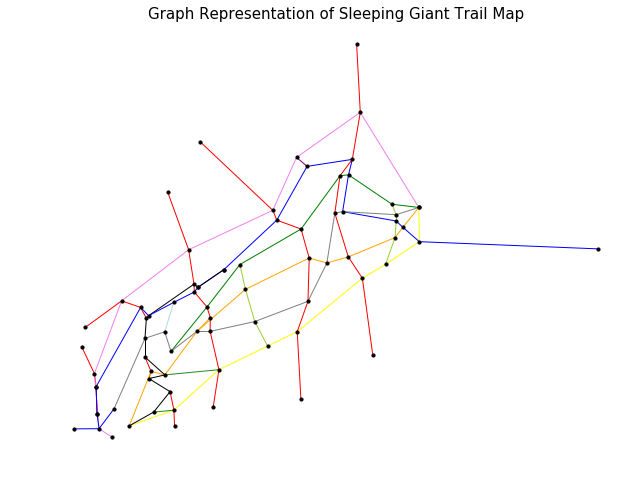

In [32]:
plt.figure(figsize=(8, 6))
nx.draw(g, pos=node_positions, edge_color=edge_colors, node_size=10, node_color='black')
plt.title('Graph Representation of Sleeping Giant Trail Map', size=15)
plt.show()

### shortest path

1. Find all nodes with odd degree (very easy).
(Find all trail intersections where the number of trails touching that intersection is an odd number)


2. Add edges to the graph such that all nodes of odd degree are made even. These added edges must be duplicates from the original graph (we'll assume no bushwhacking for this problem). The set of edges added should sum to the minimum distance possible (hard...np-hard to be precise).
(In simpler terms, minimize the amount of double backing on a route that hits every trail)


3. Given a starting point, find the Eulerian tour over the augmented dataset (moderately easy).
(Once we know which trails we'll be double backing on, actually calculate the route from beginning to end)

### Assumptions
Assumption 1: Required trails only

As you can see from the trail map above, there are roads along the borders of the park that could be used to connect trails, particularly the red trails. There are also some trails (Horseshoe and unmarked blazes) which are not required per the Giantmaster log, but could be helpful to prevent lengthy double backing. The inclusion of optional trails is actually an established variant of the CPP called the Rural Postman Problem. We ignore optional trails in this tutorial and focus on required trails only.

Assumption 2: Uphill == downhill

The CPP assumes that the cost of walking a trail is equivalent to its distance, regardless of which direction it is walked. However, some of these trails are rather hilly and will require more energy to walk up than down. Some metric that combines both distance and elevation change over a directed graph could be incorporated into an extension of the CPP called the Windy Postman Problem.

Assumption 3: No parallel edges (trails)

While possible, the inclusion of parallel edges (multiple trails connecting the same two nodes) adds complexity to computation. Luckily this only occurs twice here (Blue <=> Red Diamond and Blue <=> Tower Trail). This is addressed by a bit of a hack to the edge list: duplicate nodes are included with a _dupe suffix to capture every trail while maintaining uniqueness in the edges. The CPP implementation in the postman_problems package I wrote robustly handles parallel edges in a more elegant way if you'd like to solve the CPP on your own graph with many parallel edges.

In [36]:
# step 1
# Question: why is it important to make the odd number degrees even???
# BECAUSE even numbered degrees allow to belong and end at the same starting point!!
# Explanation here: https://www.youtube.com/watch?v=spaUY8PlyYA
# Calculate list of nodes with odd degree
nodes_odd_degree = [v for v, d in g.degree() if d % 2 == 1]

# Preview
nodes_odd_degree[0:5]

['rs_end_north',
 'rs_end_south',
 'rc_end_north',
 'rc_end_south',
 'rt_end_north']

step 2

1. Compute all possible pairs of odd degree nodes.
2. Compute the shortest path between each node pair calculated in 1.
3. Create a complete graph connecting every node pair in 1. with shortest path distance attributes calculated in 2.
4. Compute a minimum weight matching of the graph calculated in 3. 
(This boils down to determining how to pair the odd nodes such that the sum of the distance between the pairs is as small as possible).
5. Augment the original graph with the shortest paths between the node pairs calculated in 4.

In [37]:
# Step 2.1: Compute Node Pairs
# Compute all pairs of odd nodes. in a list of tuples
# graph is undirected, so we don't care about order
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))

# Preview pairs of odd degree nodes
odd_node_pairs[0:10]

[('rs_end_north', 'rs_end_south'),
 ('rs_end_north', 'rc_end_north'),
 ('rs_end_north', 'rc_end_south'),
 ('rs_end_north', 'rt_end_north'),
 ('rs_end_north', 'o_rt'),
 ('rs_end_north', 'y_rt'),
 ('rs_end_north', 'rt_end_south'),
 ('rs_end_north', 'rh_end_north'),
 ('rs_end_north', 'rh_end_tt_1'),
 ('rs_end_north', 'rh_end_tt_2')]

In [43]:
# Counts
print('Number of pairs: {}'.format(len(odd_node_pairs)))

Number of pairs: 630


In [44]:
# Step 2.2: Compute Shortest Paths between Node Pairs

def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute shortest distance between each pair of nodes in a graph.  Return a dictionary keyed on node pairs (tuples)."""
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances

# Compute shortest paths.  Return a dictionary with node pairs keys and a single value equal to shortest path distance.
odd_node_pairs_shortest_paths = get_shortest_paths_distances(g, odd_node_pairs, 'distance')

# Preview with a bit of hack (there is no head/slice method for dictionaries).
dict(list(odd_node_pairs_shortest_paths.items())[0:10])

{('rs_end_north', 'rs_end_south'): 7,
 ('rs_end_north', 'rc_end_north'): 4,
 ('rs_end_north', 'rc_end_south'): 8,
 ('rs_end_north', 'rt_end_north'): 5,
 ('rs_end_north', 'o_rt'): 7,
 ('rs_end_north', 'y_rt'): 9,
 ('rs_end_north', 'rt_end_south'): 10,
 ('rs_end_north', 'rh_end_north'): 6,
 ('rs_end_north', 'rh_end_tt_1'): 7,
 ('rs_end_north', 'rh_end_tt_2'): 9}

In [49]:
# Step 2.3: Create Complete Graph
def create_complete_graph(pair_weights, flip_weights=True):
    """
    Create a completely connected graph using a list of vertex pairs and the shortest path distances between them
    Parameters: 
        pair_weights: list[tuple] from the output of get_shortest_paths_distances
        flip_weights: Boolean. Should we negate the edge attribute in pair_weights?
    """
    g = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = - v if flip_weights else v
        g.add_edge(k[0], k[1], attr_dict={'distance': v, 'weight': wt_i})
    return g

# Generate the complete graph
g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)

# Counts
print('Number of nodes: {}'.format(len(g_odd_complete.nodes())))
print('Number of edges: {}'.format(len(g_odd_complete.edges())))

Number of nodes: 36
Number of edges: 630


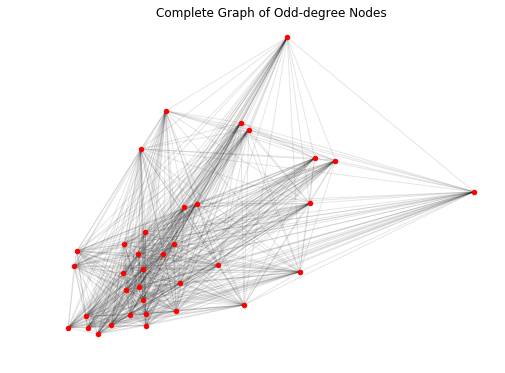

In [50]:
# Plot the complete graph of odd-degree nodes
plt.figure(figsize=(8, 6))
pos_random = nx.random_layout(g_odd_complete)
nx.draw_networkx_nodes(g_odd_complete, node_positions, node_size=20, node_color="red")
nx.draw_networkx_edges(g_odd_complete, node_positions, alpha=0.1)
plt.axis('off')
plt.title('Complete Graph of Odd-degree Nodes')
plt.show()

In [51]:
# Step 2.4: Compute Minimum Weight Matching
# Compute min weight matching.
# You need to find the odd degree node pairs whose combined sum (of distance between them) is as small as possible.
# So for your problem, this boils down to selecting the optimal 18 edges (36 odd degree nodes / 2) from the hairball of a graph generated in 2.3.
# Note: max_weight_matching uses the 'weight' attribute by default as the attribute to maximize.
odd_matching_dupes = nx.algorithms.max_weight_matching(g_odd_complete, True)

print('Number of edges in matching: {}'.format(len(odd_matching_dupes)))

Number of edges in matching: 18


In [52]:
# Preview of matching with dupes
odd_matching_dupes

{('b_bv', 'rh_end_tt_3'),
 ('b_bw', 'y_rh'),
 ('g_gy1', 'y_rt'),
 ('nature_end_west', 'rs_end_north'),
 ('o_rt', 'g_gy2'),
 ('o_w_1', 'rt_end_south'),
 ('o_y_tt_end_west', 'rt_end_north'),
 ('rc_end_south', 'o_tt'),
 ('rd_end_north', 'v_end_east'),
 ('rh_end_north', 'g_w'),
 ('rh_end_south', 'b_end_west'),
 ('rh_end_tt_1', 'w_bw'),
 ('rh_end_tt_2', 'b_end_east'),
 ('rh_end_tt_4', 'b_tt_3'),
 ('rs_end_south', 'y_gy2'),
 ('v_bv', 'rd_end_south'),
 ('v_end_west', 'b_v'),
 ('y_gy1', 'rc_end_north')}

{'b_bw': 'y_rh',
 'rd_end_north': 'v_end_east',
 'rh_end_north': 'g_w',
 'v_end_west': 'b_v',
 'rc_end_south': 'o_tt',
 'rs_end_south': 'y_gy2',
 'v_bv': 'rd_end_south',
 'o_rt': 'g_gy2',
 'y_gy1': 'rc_end_north',
 'g_gy1': 'y_rt',
 'rh_end_tt_4': 'b_tt_3',
 'o_w_1': 'rt_end_south',
 'rh_end_south': 'b_end_west',
 'b_bv': 'rh_end_tt_3',
 'rh_end_tt_2': 'b_end_east',
 'rh_end_tt_1': 'w_bw',
 'o_y_tt_end_west': 'rt_end_north',
 'nature_end_west': 'rs_end_north'}

In [58]:
# Convert matching to list of deduped tuples
odd_matching = list(pd.unique([tuple(sorted([k, v])) for k, v in odd_matching_dupes]))

# Counts
print('Number of edges in matching (deduped): {}'.format(len(odd_matching)))

Number of edges in matching (deduped): 18


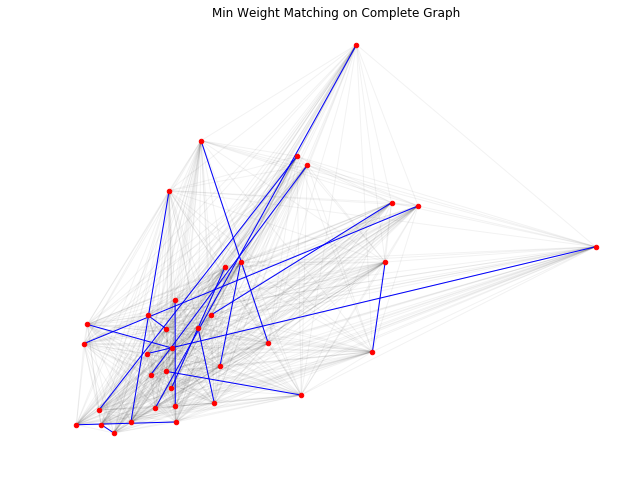

In [60]:
plt.figure(figsize=(8, 6))

# Plot the complete graph of odd-degree nodes
nx.draw(g_odd_complete, pos=node_positions, node_size=20, alpha=0.05)

# Create a new graph to overlay on g_odd_complete with just the edges from the min weight matching
g_odd_complete_min_edges = nx.Graph(odd_matching)
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, edge_color='blue', node_color='red')

plt.title('Min Weight Matching on Complete Graph')
plt.show()

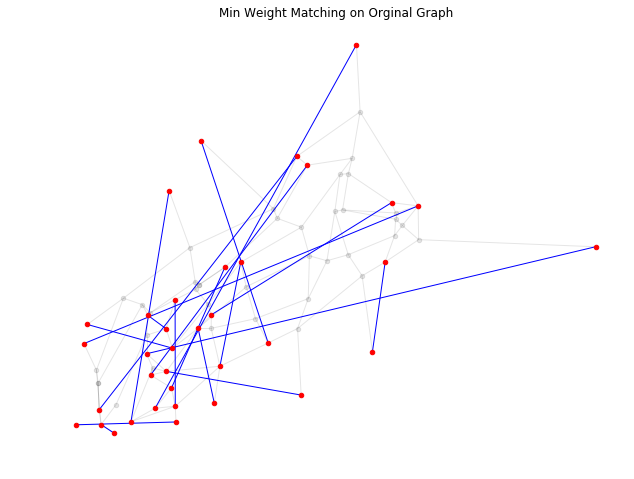

In [61]:
plt.figure(figsize=(8, 6))

# Plot the original trail map graph
nx.draw(g, pos=node_positions, node_size=20, alpha=0.1, node_color='black')

# Plot graph to overlay with just the edges from the min weight matching
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, alpha=1, node_color='red', edge_color='blue')

plt.title('Min Weight Matching on Orginal Graph')
plt.show()